In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import os

import pandas as pd
pd.options.mode.chained_assignment = None # avoids assignment warning
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

import librosa
import sklearn
import json

# Import for visualization
import matplotlib as mpl
#cmap = mpl.cm.get_cmap('coolwarm')
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd
# import cv2

# Import KaggleDatasets for accessing Kaggle datasets
# from kaggle_datasets import KaggleDatasets

# WandB for experiment tracking
# import wandb

import torchaudio
# import plotly.express as px
from IPython.display import Audio
# from shapely.geometry import Point

# import plotly.express as px

from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch


In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
!ls ../../data/2024

eBird_Taxonomy_v2021.csv  test_soundscapes  train_metadata.csv
sample_submission.csv	  train_audio	    unlabeled_soundscapes


In [4]:
df = pd.read_csv("only_pl_no_dups_5sec_leq20.csv")
df.head()

,wav_path,label
0,../../preprocessed_data/5sec_wavs/asbfly_XC134...,asbfly
1,../../preprocessed_data/5sec_wavs/asbfly_XC164...,asbfly
2,../../preprocessed_data/5sec_wavs/asbfly_XC175...,asbfly
3,../../preprocessed_data/5sec_wavs/asbfly_XC207...,asbfly
4,../../preprocessed_data/5sec_wavs/asbfly_XC209...,asbfly


In [5]:
# df['secondary_labels'].unique()

In [6]:
lb = LabelEncoder()
lb.fit(df['label'])

LabelEncoder()

In [7]:
lb.classes_[:10], lb.transform(['asbfly'])

(array(['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2', 'asiope1',
        'aspfly1', 'aspswi1', 'barfly1', 'barswa'], dtype=object),
 array([0]))

In [8]:
df['target'] = lb.transform(df['label'])

In [9]:
df['target'].head(2)

0    0
1    0
Name: target, dtype: int64

In [10]:
from scipy import signal as sci_signal

In [11]:
def _pad_tensor(x, length):
    _pad = 0.0
    assert x.ndim == 2
    x = np.pad(x, [[0, 0], [0, length - x.shape[1]]], mode="constant", constant_values=_pad)
    return x


def prepare_tensor(inputs, out_steps=1):
    max_len = max((x.shape[1] for x in inputs))
    remainder = max_len % out_steps
    pad_len = max_len + (out_steps - remainder) if remainder > 0 else max_len
    return np.stack([_pad_tensor(x, pad_len) for x in inputs])


class BalancedDataset(Dataset):
    def __init__(self, df, segment_size = 5, num_utter_per_class = 2, lazy_load = False, is_eval = False):
        self.df = df
        self.segment_size = segment_size # Size of random slices in seconds
        self.lazy_load = lazy_load
        self.num_utter_per_class = num_utter_per_class
        self.is_eval = is_eval
        self.classes, self.items = self.__parse_items()
        
    def __len__(self):
        return len(self.df)

    def __parse_items(self):
        class_to_utters = {}
        for i in range(self.df.shape[0]):
            path_ = self.df["wav_path"].values[i]
            class_name = self.df['target'].values[i]
            if class_name in class_to_utters.keys():
                class_to_utters[class_name].append(path_)
            else:
                class_to_utters[class_name] = [
                    path_,
                ]

        # skip classes with number of samples >= self.num_utter_per_class
        if(self.is_eval):
            class_to_utters = {k: v for (k, v) in class_to_utters.items()}
        else:
            class_to_utters = {k: v for (k, v) in class_to_utters.items() if len(v) >= self.num_utter_per_class}

        classes = list(class_to_utters.keys())
        classes.sort()

        new_items = []
        for i in range(self.df.shape[0]):
            path_ = self.df["wav_path"].values[i]
            class_name = self.df['target'].values[i]
            # ignore filtered classes
            if class_name not in classes:
                continue
            # ignore small audios
#             if self.load_wav(path_).shape[0] - self.seq_len <= 0:
#                 continue

            new_items.append({"wav_file_path": path_, "class_name": class_name})

        return classes, new_items    
    
    def __getitem__(self, idx):
        return self.items[idx]
    
    def collate_fn(self, batch):
        # get the batch class_ids
        labels = []
        feats = []
        for item in batch:
            utter_path = item["wav_file_path"]
            class_name = item["class_name"]

            # get classid
            class_id = class_name
            

            y, sr = librosa.load(utter_path, sr=None)
            y = np.asarray(y, dtype=np.float32)

            # HANDLE NaNs
#             mean_signal = np.nanmean(y)
#             input_audio = np.nan_to_num(y, nan=mean_signal) if np.isnan(y).mean() < 1 else np.zeros_like(y)

#             # SPECTROGRAM
#             frequencies, times, spec_data = sci_signal.spectrogram(
#                 input_audio, 
#                 fs=sr, 
#                 nfft=1024, 
#                 nperseg=512, 
#                 noverlap=256, 
#                 window='hann'
#             )

#             # FILTER LOWER AND HIGHER FREQUENCIES
#             valid_freq = (frequencies >= 100) & (frequencies <= 16000)
#             spec_data = spec_data[valid_freq, :]

#             # COMPUTE LOG SPEC
#             spec_data = np.log10(spec_data + 1e-20)

#             # MIN/MAX NORMALIZATION
#             spec_data = spec_data - spec_data.min()
#             spec_data = spec_data / spec_data.max()

#             spec_data = cv2.resize(spec_data, (256, 256), interpolation=cv2.INTER_AREA)
            
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=182, n_fft = 2048, hop_length = 256,fmin=1000, fmax=16000)
            spec_data = librosa.power_to_db(S, ref=np.max)
#             print(melspec.shape)
#             if(melspec.shape[1] == 251):
            feats.append(torch.FloatTensor(spec_data))

            labels.append(class_id)

        feats = torch.stack(feats)
        labels = torch.LongTensor(labels)

        return feats, labels

def my_collate_fn(batch):

    melspec = [x[0] for x in batch]
    label = [x[1] for x in batch]
    label = np.array(label)

    melspec = prepare_tensor(melspec)
    
#     print(type(label))

    return torch.FloatTensor(melspec), torch.LongTensor(label)

In [12]:
import math
import random
from typing import Callable, List, Union

from torch.utils.data.sampler import BatchSampler, Sampler, SubsetRandomSampler


class SubsetSampler(Sampler):
    """
    Samples elements sequentially from a given list of indices.

    Args:
        indices (list): a sequence of indices
    """

    def __init__(self, indices):
        super().__init__(indices)
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)


class PerfectBatchSampler(Sampler):
    """
    Samples a mini-batch of indices for a balanced class batching

    Args:
        dataset_items(list): dataset items to sample from.
        classes (list): list of classes of dataset_items to sample from.
        batch_size (int): total number of samples to be sampled in a mini-batch.
        num_gpus (int): number of GPU in the data parallel mode.
        shuffle (bool): if True, samples randomly, otherwise samples sequentially.
        drop_last (bool): if True, drops last incomplete batch.
    """

    def __init__(
        self,
        dataset_items,
        classes,
        batch_size,
        num_classes_in_batch,
        num_gpus=1,
        shuffle=True,
        drop_last=False,
        label_key="class_name",
    ):
        super().__init__(dataset_items)
        assert (
            batch_size % (num_classes_in_batch * num_gpus) == 0
        ), "Batch size must be divisible by number of classes times the number of data parallel devices (if enabled)."

        label_indices = {}
        for idx, item in enumerate(dataset_items):
            label = item[label_key]
            if label not in label_indices.keys():
                label_indices[label] = [idx]
            else:
                label_indices[label].append(idx)

        if shuffle:
            self._samplers = [SubsetRandomSampler(label_indices[key]) for key in classes]
        else:
            self._samplers = [SubsetSampler(label_indices[key]) for key in classes]

        self._batch_size = batch_size
        self._drop_last = drop_last
        self._dp_devices = num_gpus
        self._num_classes_in_batch = num_classes_in_batch

    def __iter__(self):
        batch = []
        if self._num_classes_in_batch != len(self._samplers):
#             print(len(self._samplers), self._num_classes_in_batch)
            valid_samplers_idx = random.sample(range(len(self._samplers)), self._num_classes_in_batch)
        else:
            valid_samplers_idx = None

        iters = [iter(s) for s in self._samplers]
        done = False

        while True:
            b = []
            for i, it in enumerate(iters):
                if valid_samplers_idx is not None and i not in valid_samplers_idx:
                    continue
                idx = next(it, None)
                if idx is None:
                    done = True
                    break
                b.append(idx)
            if done:
                break
            batch += b
            if len(batch) == self._batch_size:
                yield batch
                batch = []
                if valid_samplers_idx is not None:
                    valid_samplers_idx = random.sample(range(len(self._samplers)), self._num_classes_in_batch)

        if not self._drop_last:
            if len(batch) > 0:
                groups = len(batch) // self._num_classes_in_batch
                if groups % self._dp_devices == 0:
                    yield batch
                else:
                    batch = batch[: (groups // self._dp_devices) * self._dp_devices * self._num_classes_in_batch]
                    if len(batch) > 0:
                        yield batch

    def __len__(self):
        class_batch_size = self._batch_size // self._num_classes_in_batch
        return min(((len(s) + class_batch_size - 1) // class_batch_size) for s in self._samplers)


def identity(x):
    return x


class SortedSampler(Sampler):
    """Samples elements sequentially, always in the same order.

    Taken from https://github.com/PetrochukM/PyTorch-NLP

    Args:
        data (iterable): Iterable data.
        sort_key (callable): Specifies a function of one argument that is used to extract a
            numerical comparison key from each list element.

    Example:
        >>> list(SortedSampler(range(10), sort_key=lambda i: -i))
        [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

    """

    def __init__(self, data, sort_key: Callable = identity):
        super().__init__(data)
        self.data = data
        self.sort_key = sort_key
        zip_ = [(i, self.sort_key(row)) for i, row in enumerate(self.data)]
        zip_ = sorted(zip_, key=lambda r: r[1])
        self.sorted_indexes = [item[0] for item in zip_]

    def __iter__(self):
        return iter(self.sorted_indexes)

    def __len__(self):
        return len(self.data)


class BucketBatchSampler(BatchSampler):
    """Bucket batch sampler

    Adapted from https://github.com/PetrochukM/PyTorch-NLP

    Args:
        sampler (torch.data.utils.sampler.Sampler):
        batch_size (int): Size of mini-batch.
        drop_last (bool): If `True` the sampler will drop the last batch if its size would be less
            than `batch_size`.
        data (list): List of data samples.
        sort_key (callable, optional): Callable to specify a comparison key for sorting.
        bucket_size_multiplier (int, optional): Buckets are of size
            `batch_size * bucket_size_multiplier`.

    Example:
        >>> sampler = WeightedRandomSampler(weights, len(weights))
        >>> sampler = BucketBatchSampler(sampler, data=data_items, batch_size=32, drop_last=True)
    """

    def __init__(
        self,
        sampler,
        data,
        batch_size,
        drop_last,
        sort_key: Union[Callable, List] = identity,
        bucket_size_multiplier=100,
    ):
        super().__init__(sampler, batch_size, drop_last)
        self.data = data
        self.sort_key = sort_key
        _bucket_size = batch_size * bucket_size_multiplier
        if hasattr(sampler, "__len__"):
            _bucket_size = min(_bucket_size, len(sampler))
        self.bucket_sampler = BatchSampler(sampler, _bucket_size, False)

    def __iter__(self):
        for idxs in self.bucket_sampler:
            bucket_data = [self.data[idx] for idx in idxs]
            sorted_sampler = SortedSampler(bucket_data, self.sort_key)
            for batch_idx in SubsetRandomSampler(list(BatchSampler(sorted_sampler, self.batch_size, self.drop_last))):
                sorted_idxs = [idxs[i] for i in batch_idx]
                yield sorted_idxs

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        return math.ceil(len(self.sampler) / self.batch_size)

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.15, random_state = 42, stratify=df['label'])
df_train.shape, df_val.shape

((19699, 3), (3477, 3))

In [14]:
df_val.label.nunique()

182

In [15]:
df_val.target.value_counts()

57     73
40     73
39     72
10     72
107    72
       ..
11      3
165     3
5       2
92      2
119     2
Name: target, Length: 182, dtype: int64

In [16]:
# len(val_dataset.classes), df_val.labels.nunique()

# Balanced sampler

In [17]:
df_train.head()

,wav_path,label,target
16821,../../preprocessed_data/5sec_wavs/litgre1_XC82...,litgre1,107
3031,../../preprocessed_data/5sec_wavs/blrwar1_XC18...,blrwar1,20
9526,../../preprocessed_data/5sec_wavs/gargan_XC131...,gargan,59
10488,../../preprocessed_data/5sec_wavs/grecou1_XC84...,grecou1,64
21134,../../preprocessed_data/5sec_wavs/wemhar1_XC36...,wemhar1,166


In [18]:
num_utter_per_class = 2
num_classes_in_batch = 182

train_dataset = BalancedDataset(df_train, segment_size = 5, num_utter_per_class = num_utter_per_class, lazy_load = True, is_eval = False)
val_dataset = BalancedDataset(df_val, segment_size = 5, num_utter_per_class = num_utter_per_class ,lazy_load = True, is_eval = True)

is_val = True
classes = val_dataset.classes

train_sampler = PerfectBatchSampler(
    train_dataset.items,
    classes,
    batch_size=num_classes_in_batch * num_utter_per_class,  # total batch size
    num_classes_in_batch=num_classes_in_batch,
    num_gpus=1,
    shuffle=True,
    drop_last=True,
)

eval_sampler = PerfectBatchSampler(
    val_dataset.items,
    classes,
    batch_size=num_classes_in_batch * 1,  # total batch size
    num_classes_in_batch=num_classes_in_batch,
    num_gpus=1,
    shuffle=not is_val,
    drop_last=True,
)

train_dataloader = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, num_workers=4,  batch_sampler=train_sampler)

val_dataloader = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, num_workers=4,  batch_sampler=eval_sampler)

In [19]:
%%time
batch = next(iter(train_dataloader))
batch[0].shape, batch[1].shape

CPU times: user 142 ms, sys: 208 ms, total: 349 ms
Wall time: 59.6 s


(torch.Size([364, 182, 626]), torch.Size([364]))

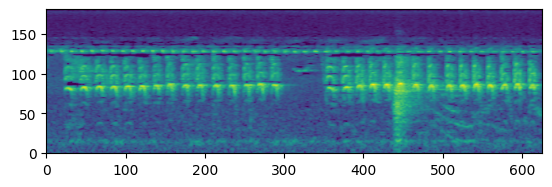

In [20]:
plt.imshow(batch[0][2].cpu().numpy(),origin='lower')

In [21]:
import torch
import torch.nn.functional as F
from torch import nn


# adapted from https://github.com/cvqluu/GE2E-Loss
class GE2ELoss(nn.Module):
    def __init__(self, init_w=10.0, init_b=-5.0, loss_method="softmax"):
        """
        Implementation of the Generalized End-to-End loss defined in https://arxiv.org/abs/1710.10467 [1]
        Accepts an input of size (N, M, D)
            where N is the number of speakers in the batch,
            M is the number of utterances per speaker,
            and D is the dimensionality of the embedding vector (e.g. d-vector)
        Args:
            - init_w (float): defines the initial value of w in Equation (5) of [1]
            - init_b (float): definies the initial value of b in Equation (5) of [1]
        """
        super().__init__()
        # pylint: disable=E1102
        self.w = nn.Parameter(torch.tensor(init_w))
        # pylint: disable=E1102
        self.b = nn.Parameter(torch.tensor(init_b))
        self.loss_method = loss_method

        print(" > Initialized Generalized End-to-End loss")

        assert self.loss_method in ["softmax", "contrast"]

        if self.loss_method == "softmax":
            self.embed_loss = self.embed_loss_softmax
        if self.loss_method == "contrast":
            self.embed_loss = self.embed_loss_contrast

    # pylint: disable=R0201
    def calc_new_centroids(self, dvecs, centroids, spkr, utt):
        """
        Calculates the new centroids excluding the reference utterance
        """
        excl = torch.cat((dvecs[spkr, :utt], dvecs[spkr, utt + 1 :]))
        excl = torch.mean(excl, 0)
        new_centroids = []
        for i, centroid in enumerate(centroids):
            if i == spkr:
                new_centroids.append(excl)
            else:
                new_centroids.append(centroid)
        return torch.stack(new_centroids)

    def calc_cosine_sim(self, dvecs, centroids):
        """
        Make the cosine similarity matrix with dims (N,M,N)
        """
        cos_sim_matrix = []
        for spkr_idx, speaker in enumerate(dvecs):
            cs_row = []
            for utt_idx, utterance in enumerate(speaker):
                new_centroids = self.calc_new_centroids(dvecs, centroids, spkr_idx, utt_idx)
                # vector based cosine similarity for speed
                cs_row.append(
                    torch.clamp(
                        torch.mm(
                            utterance.unsqueeze(1).transpose(0, 1),
                            new_centroids.transpose(0, 1),
                        )
                        / (torch.norm(utterance) * torch.norm(new_centroids, dim=1)),
                        1e-6,
                    )
                )
            cs_row = torch.cat(cs_row, dim=0)
            cos_sim_matrix.append(cs_row)
        return torch.stack(cos_sim_matrix)

    # pylint: disable=R0201
    def embed_loss_softmax(self, dvecs, cos_sim_matrix):
        """
        Calculates the loss on each embedding $L(e_{ji})$ by taking softmax
        """
        N, M, _ = dvecs.shape
        L = []
        for j in range(N):
            L_row = []
            for i in range(M):
                L_row.append(-F.log_softmax(cos_sim_matrix[j, i], 0)[j])
            L_row = torch.stack(L_row)
            L.append(L_row)
        return torch.stack(L)

    # pylint: disable=R0201
    def embed_loss_contrast(self, dvecs, cos_sim_matrix):
        """
        Calculates the loss on each embedding $L(e_{ji})$ by contrast loss with closest centroid
        """
        N, M, _ = dvecs.shape
        L = []
        for j in range(N):
            L_row = []
            for i in range(M):
                centroids_sigmoids = torch.sigmoid(cos_sim_matrix[j, i])
                excl_centroids_sigmoids = torch.cat((centroids_sigmoids[:j], centroids_sigmoids[j + 1 :]))
                L_row.append(1.0 - torch.sigmoid(cos_sim_matrix[j, i, j]) + torch.max(excl_centroids_sigmoids))
            L_row = torch.stack(L_row)
            L.append(L_row)
        return torch.stack(L)

    def forward(self, x, _label=None):
        """
        Calculates the GE2E loss for an input of dimensions (num_speakers, num_utts_per_speaker, dvec_feats)
        """

        assert x.size()[1] >= 2

        centroids = torch.mean(x, 1)
        cos_sim_matrix = self.calc_cosine_sim(x, centroids)
        torch.clamp(self.w, 1e-6)
        cos_sim_matrix = self.w * cos_sim_matrix + self.b
        L = self.embed_loss(x, cos_sim_matrix)
        return L.mean()


# adapted from https://github.com/clovaai/voxceleb_trainer/blob/master/loss/angleproto.py
class AngleProtoLoss(nn.Module):
    """
    Implementation of the Angular Prototypical loss defined in https://arxiv.org/abs/2003.11982
        Accepts an input of size (N, M, D)
            where N is the number of speakers in the batch,
            M is the number of utterances per speaker,
            and D is the dimensionality of the embedding vector
        Args:
            - init_w (float): defines the initial value of w
            - init_b (float): definies the initial value of b
    """

    def __init__(self, init_w=10.0, init_b=-5.0):
        super().__init__()
        # pylint: disable=E1102
        self.w = nn.Parameter(torch.tensor(init_w))
        # pylint: disable=E1102
        self.b = nn.Parameter(torch.tensor(init_b))
        self.criterion = torch.nn.CrossEntropyLoss()

        print(" > Initialized Angular Prototypical loss")

    def forward(self, x, _label=None):
        """
        Calculates the AngleProto loss for an input of dimensions (num_speakers, num_utts_per_speaker, dvec_feats)
        """
#         print(x.size()[1])
#         assert x.size()[1] >= 2

        out_anchor = torch.mean(x[:, 1:, :], 1)
        out_positive = x[:, 0, :]
        num_speakers = out_anchor.size()[0]

        cos_sim_matrix = F.cosine_similarity(
            out_positive.unsqueeze(-1).expand(-1, -1, num_speakers),
            out_anchor.unsqueeze(-1).expand(-1, -1, num_speakers).transpose(0, 2),
        )
        torch.clamp(self.w, 1e-6)
        cos_sim_matrix = cos_sim_matrix * self.w + self.b
        label = torch.arange(num_speakers).to(cos_sim_matrix.device)
        L = self.criterion(cos_sim_matrix, label)
        return L


class SoftmaxLoss(nn.Module):
    """
    Implementation of the Softmax loss as defined in https://arxiv.org/abs/2003.11982
        Args:
            - embedding_dim (float): speaker embedding dim
            - n_speakers (float): number of speakers
    """

    def __init__(self, embedding_dim, n_speakers):
        super().__init__()

        self.criterion = torch.nn.CrossEntropyLoss()
        self.fc = nn.Linear(embedding_dim, n_speakers)

        print("Initialised Softmax Loss")

    def forward(self, x, label=None):
        # reshape for compatibility
        x = x.reshape(-1, x.size()[-1])
        label = label.reshape(-1)

        x = self.fc(x)
        L = self.criterion(x, label)

        return L

    def inference(self, embedding):
        x = self.fc(embedding)
        activations = torch.nn.functional.softmax(x, dim=1).squeeze(0)
        class_id = torch.argmax(activations)
        return class_id


class SoftmaxAngleProtoLoss(nn.Module):
    """
    Implementation of the Softmax AnglePrototypical loss as defined in https://arxiv.org/abs/2009.14153
        Args:
            - embedding_dim (float): speaker embedding dim
            - n_speakers (float): number of speakers
            - init_w (float): defines the initial value of w
            - init_b (float): definies the initial value of b
    """

    def __init__(self, embedding_dim, n_speakers, init_w=10.0, init_b=-5.0):
        super().__init__()

        self.softmax = SoftmaxLoss(embedding_dim, n_speakers)
        self.angleproto = AngleProtoLoss(init_w, init_b)

        print("Initialised SoftmaxAnglePrototypical Loss")

    def forward(self, x, label=None):
        """
        Calculates the SoftmaxAnglePrototypical loss for an input of dimensions (num_speakers, num_utts_per_speaker, dvec_feats)
        """

        Lp = self.angleproto(x)

        Ls = self.softmax(x, label)

        return Ls + Lp

In [22]:
from torch import nn
import torch
import torch.nn.functional as F
import torch.optim as optim

class ReferenceEncoder(nn.Module):
    """NN module creating a fixed size prosody embedding from a spectrogram.

    inputs: mel spectrograms [batch_size, num_spec_frames, num_mel]
    outputs: [batch_size, embedding_dim]
    """

    def __init__(self, num_mel, embedding_dim, use_nonlinear_proj = False):

        super().__init__()
        self.num_mel = num_mel
        filters = [1] + [32, 32, 64, 64, 128, 128]
        num_layers = len(filters) - 1
        convs = [
            nn.Conv2d(
                in_channels=filters[i], out_channels=filters[i + 1], kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
            )
            for i in range(num_layers)
        ]
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList([nn.BatchNorm2d(num_features=filter_size) for filter_size in filters[1:]])

        post_conv_height = self.calculate_post_conv_height(num_mel, 3, 2, 1, num_layers)
        self.recurrence = nn.GRU(
            input_size=filters[-1] * post_conv_height, hidden_size=embedding_dim, batch_first=True
        )

        self.dropout = nn.Dropout(p=0.5)

        self.use_nonlinear_proj = use_nonlinear_proj

        if(self.use_nonlinear_proj):
            self.proj = nn.Linear(embedding_dim, embedding_dim)
            nn.init.xavier_normal_(self.proj.weight) # Good init for projection
            # self.proj.bias.data.zero_() # Not random bias to "move" z

#         self.classifier_layer = nn.Linear(embedding_dim, num_classes)

    def forward(self, inputs):
        batch_size = inputs.size(0)
        x = inputs.view(batch_size, 1, -1, self.num_mel)
        # x: 4D tensor [batch_size, num_channels==1, num_frames, num_mel]
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x)
            x = bn(x)
            x = F.relu(x)

        x = x.transpose(1, 2)
        # x: 4D tensor [batch_size, post_conv_width,
        #               num_channels==128, post_conv_height]
        post_conv_width = x.size(1)
        x = x.contiguous().view(batch_size, post_conv_width, -1)
        # x: 3D tensor [batch_size, post_conv_width,
        #               num_channels*post_conv_height]
        self.recurrence.flatten_parameters()
        _, out = self.recurrence(x)
        # out: 3D tensor [seq_len==1, batch_size, encoding_size=128]

        if(self.use_nonlinear_proj):
            out = torch.tanh(self.proj(out))
            out = self.dropout(out)

        return out.squeeze(0)

    @staticmethod
    def calculate_post_conv_height(height, kernel_size, stride, pad, n_convs):
        """Height of spec after n convolutions with fixed kernel/stride/pad."""
        for _ in range(n_convs):
            height = (height - kernel_size + 2 * pad) // stride + 1
        return height

class ReferenceEncoderRepresentation(nn.Module):
    """NN module creating a fixed size prosody embedding from a spectrogram.

    inputs: mel spectrograms [batch_size, num_spec_frames, num_mel]
    outputs: [batch_size, embedding_dim]
    """

    def __init__(self, num_mel, embedding_dim, num_classes, use_nonlinear_proj = False):

        super().__init__()
        self.num_mel = num_mel
        self.re = ReferenceEncoder(num_mel, embedding_dim, use_nonlinear_proj = False)

        self.embedding_layer = nn.Linear(embedding_dim, embedding_dim)
        self.classifier_layer = nn.Linear(embedding_dim, num_classes)

    def forward(self, inputs):
        # print(inputs.shape)
        inputs = inputs.permute(0,2,1)
        # print(inputs.shape)
        # print(inputs.view())

        out = self.re(inputs)

        out = self.embedding_layer(out)
        
        pred = self.classifier_layer(out)

        return out, pred
    
    

In [23]:
class XCA(nn.Module):
    """ Cross-Covariance Attention (XCA) operation where the channels are updated using a weighted
     sum. The weights are obtained from the (softmax normalized) Cross-covariance
    matrix (Q^T K \\in d_h \\times d_h)
    """

    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 3, 1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'temperature'}

In [24]:
n = XCA(dim = 128)

x = torch.rand((1,64,128))

out, attn = n(x)
out.shape

torch.Size([1, 64, 128])

In [25]:
out[0].sum()

tensor(7.5594, grad_fn=<SumBackward0>)

In [26]:
class XCA_dvector(nn.Module):
    """LSTM-based d-vector with XCA attention."""

    def __init__(
        self,
        num_layers=3,
        dim_input=40,
        dim_cell=256,
        dim_emb=256,
        seg_len=160,
    ):
        super().__init__()
        self.lstm = nn.LSTM(dim_input, dim_cell, num_layers, batch_first=True)
        self.embedding = nn.Linear(dim_cell, dim_emb)
        self.attn = XCA(dim = dim_emb)
        self.seg_len = seg_len
        

    def forward(self, inputs):
        """Forward a batch through network."""
        lstm_outs, _ = self.lstm(inputs)  # (batch, seg_len, dim_cell)
        embeds = torch.tanh(self.embedding(lstm_outs))  # (batch, seg_len, dim_emb)
        embeds, _ = self.attn(embeds)
#         print(embeds.shape)
        embeds = torch.sum(embeds, dim=1)
#         print(embeds.shape)
        return embeds.div(embeds.norm(p=2, dim=-1, keepdim=True))

In [27]:
class Dvector(nn.Module):
    """LSTM-based d-vector with XCA attention."""

    def __init__(
        self,
        num_layers=3,
        dim_input=40,
        dim_cell=256,
        dim_emb=256,
        seg_len=160,
    ):
        super().__init__()
        self.lstm = nn.LSTM(dim_input, dim_cell, num_layers, batch_first=True)
        self.embedding = nn.Linear(dim_cell, dim_emb)
        self.linear = nn.Linear(dim_emb, 1)
        self.seg_len = seg_len
        

    def forward(self, inputs):
        """Forward a batch through network."""
        lstm_outs, _ = self.lstm(inputs)  # (batch, seg_len, dim_cell)
        embeds = torch.tanh(self.embedding(lstm_outs))  # (batch, seg_len, dim_emb)
#         embeds, _ = self.attn(embeds)
        attn_weights = F.softmax(self.linear(embeds), dim=1)
        embeds = torch.sum(embeds * attn_weights, dim=1)
        return embeds.div(embeds.norm(p=2, dim=-1, keepdim=True))

In [28]:
n = XCA_dvector()

x = torch.rand((1,64,40))

out = n(x)
out.shape

torch.Size([1, 256])

In [29]:
# base_model = efficientnet.efficientnet_b0(weights=efficientnet.EfficientNet_B0_Weights.DEFAULT)

In [30]:
# base_model

In [31]:
from torchvision.models import efficientnet

class EffNet(nn.Module):
    
    def __init__(self, n_dim, pretrained=True):
        super().__init__()

        if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
        else: weights = None
        self.base_model = efficientnet.efficientnet_b0(weights=weights)

        
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_dim, dtype=torch.float32)
    
    def forward(self, x):
        
        x = x.unsqueeze(1)
        x = x.expand(-1, 3, -1, -1)
        
        return self.base_model(x)

In [32]:
n = EffNet(256)

x = torch.rand((1,64,40))

out = n(x)
out.shape

torch.Size([1, 256])

In [33]:
def check_update(model, grad_clip, ignore_stopnet=False, amp_opt_params=None):
    r"""Check model gradient against unexpected jumps and failures"""
    skip_flag = False
    if ignore_stopnet:
        if not amp_opt_params:
            grad_norm = torch.nn.utils.clip_grad_norm_(
                [param for name, param in model.named_parameters() if "stopnet" not in name], grad_clip
            )
        else:
            grad_norm = torch.nn.utils.clip_grad_norm_(amp_opt_params, grad_clip)
    else:
        if not amp_opt_params:
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        else:
            grad_norm = torch.nn.utils.clip_grad_norm_(amp_opt_params, grad_clip)

    # compatibility with different torch versions
    if isinstance(grad_norm, float):
        if np.isinf(grad_norm):
            print(" | > Gradient is INF !!")
            skip_flag = True
    else:
        if torch.isinf(grad_norm):
            print(" | > Gradient is INF !!")
            skip_flag = True
    return grad_norm, skip_flag

## Also defining global constants
eval_num_utter_per_class = 2
eval_num_classes_in_batch = 182

num_utter_per_class = 2
num_classes_in_batch = 182

num_loader_workers = 4
grad_clip = 3

print_step = 1000
save_step = 1000
epochs = 1000
lr_decay = 0

save_path = './chpks/clustering_angular'

run_eval = True

def evaluation(model, criterion1, data_loader, global_step):
    eval_loss = 0
    ang_loss = 0
    ce_loss = 0
    
    acc_ = 0
    for _, data in enumerate(data_loader):
        with torch.no_grad():
            # setup input data
            inputs, labels = data

#             print(labels.shape)
#             print(labels.view(eval_num_utter_per_class, eval_num_classes_in_batch).shape)
            
            # agroup samples of each class in the batch. perfect sampler produces [3,2,1,3,2,1] we need [3,3,2,2,1,1]
            labels = torch.transpose(
                labels.view(eval_num_utter_per_class, eval_num_classes_in_batch), 0, 1
            ).reshape(labels.shape)
            inputs = torch.transpose(
                inputs.view(eval_num_utter_per_class, eval_num_classes_in_batch, -1), 0, 1
            ).reshape(inputs.shape)

            # dispatch data to GPU
            if use_cuda:
                inputs = inputs.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)

            # forward pass model
            outputs = model(inputs.permute(0,2,1))

            # loss computation
            loss = criterion(
                outputs.view(eval_num_classes_in_batch, outputs.shape[0] // eval_num_classes_in_batch, -1), labels
            )

            
            eval_loss += loss.item()



            
    eval_avg_loss = eval_loss / len(data_loader)

    

    # # save stats
    # dashboard_logger.eval_stats(global_step, {"loss": eval_avg_loss})
    # # plot the last batch in the evaluation
    # figures = {
    #     "UMAP Plot": plot_embeddings(outputs.detach().cpu().numpy(), c.num_classes_in_batch),
    # }
    # dashboard_logger.eval_figures(global_step, figures)
    return eval_avg_loss

import time
def train(model, optimizer, scheduler, criterion, data_loader, eval_data_loader, global_step):
    model.train()
    best_loss = float("inf")
    # best_loss = {"train_loss": None, "eval_loss": float("inf")}
    avg_loader_time = 0
    end_time = time.time()
    total_steps = 0
    for epoch in range(epochs):
        tot_loss = 0
        epoch_time = 0
        for _, data in enumerate(data_loader):
            start_time = time.time()

            # setup input data
            inputs, labels = data
            # agroup samples of each class in the batch. perfect sampler produces [3,2,1,3,2,1] we need [3,3,2,2,1,1]
            labels = torch.transpose(labels.view(num_utter_per_class, num_classes_in_batch), 0, 1).reshape(
                labels.shape
            )
            inputs = torch.transpose(inputs.view(num_utter_per_class, num_classes_in_batch, -1), 0, 1).reshape(
                inputs.shape
            )

            loader_time = time.time() - end_time
            global_step += 1

            # setup lr
            if lr_decay:
                scheduler.step()
            optimizer.zero_grad()

            # dispatch data to GPU
            if use_cuda:
                inputs = inputs.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)

            # forward pass model
            outputs = model(inputs.permute(0,2,1))

#             print(outputs.shape)
#             print(outputs.view(num_classes_in_batch, outputs.shape[0] // num_classes_in_batch, -1).shape)
#             loss computation

#             if total_steps > 50:
            loss = criterion(
                outputs.view(num_classes_in_batch, outputs.shape[0] // num_classes_in_batch, -1), labels
            )
#                 loss2 = criterion2(pred, labels)

#                 loss = loss*0.5 + loss2*0.5
                
#             else:
#                 loss2 = criterion2(pred, labels)

#                 loss = loss2
                
                
            loss.backward()
            grad_norm, _ = check_update(model, grad_clip)
            optimizer.step()

            total_steps += 1
            
            step_time = time.time() - start_time
            epoch_time += step_time

            # acumulate the total epoch loss
            tot_loss += loss.item()

            # Averaged Loader Time
            # num_loader_workers = num_loader_workers if c.num_loader_workers > 0 else 1
            avg_loader_time = (
                1 / num_loader_workers * loader_time + (num_loader_workers - 1) / num_loader_workers * avg_loader_time
                if avg_loader_time != 0
                else loader_time
            )
            current_lr = optimizer.param_groups[0]["lr"]


            if global_step % print_step == 0:
                print(
                    "   | > Step:{}  Loss:{:.5f}  GradNorm:{:.5f}  "
                    "StepTime:{:.2f}  LoaderTime:{:.2f}  AvGLoaderTime:{:.2f}  LR:{:.6f}".format(
                        global_step, loss.item(), grad_norm, step_time, loader_time, avg_loader_time, current_lr
                    ),
                    flush=True,
                )

            if global_step % save_step == 0:
                # save model
                # save_checkpoint(
                #     c, model, optimizer, None, global_step, epoch, OUT_PATH, criterion=criterion.state_dict()
                # )
                print("Saving iteration model")
                torch.save(model.state_dict(), f'{save_path}/checkpoint_{global_step}.pth')

            end_time = time.time()

        print("")
        print(
            ">>> Epoch:{}  AvgLoss: {:.5f} GradNorm:{:.5f}  "
            "EpochTime:{:.2f} AvGLoaderTime:{:.2f} ".format(
                epoch, tot_loss / len(data_loader), grad_norm, epoch_time, avg_loader_time
            ),
            flush=True,
        )
        # evaluation
        if run_eval:
            model.eval()
            eval_loss = evaluation(model, criterion, eval_data_loader, global_step)
            print("\n\n")
            print("--> EVAL PERFORMANCE")
            print(
                "   | > Epoch:{}  AvgLoss: {:.5f}".format(epoch, eval_loss),
                flush=True,
            )

            if(eval_loss < best_loss):
                print("Saving best model")
                torch.save(model.state_dict(), f'{save_path}/best_model_{global_step}.pth')
                best_loss = eval_loss
            # save the best checkpoint
            # best_loss = save_best_model(
            #     {"train_loss": None, "eval_loss": eval_loss},
            #     best_loss,
            #     c,
            #     model,
            #     optimizer,
            #     None,
            #     global_step,
            #     epoch,
            #     OUT_PATH,
            #     criterion=criterion.state_dict(),
            # )
            model.train()

    return best_loss, global_step


In [40]:
# model = Dvector(num_layers=3, dim_input=182, dim_cell=256, dim_emb=256, seg_len=509)
model = EffNet(256)


optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# criterion2 = nn.CrossEntropyLoss()
criterion = AngleProtoLoss()
scheduler = None
global_step = 0
use_cuda = True

if use_cuda:
    model = model.cuda()
    criterion.cuda()
#     criterion2.cuda()
    
num_utter_per_class = 2
num_classes_in_batch = 32

eval_num_utter_per_class = 2
eval_num_classes_in_batch = 32

train_dataset = BalancedDataset(df_train, segment_size = 5, num_utter_per_class = num_utter_per_class, lazy_load = True, is_eval = False)
val_dataset = BalancedDataset(df_val, segment_size = 5, num_utter_per_class = num_utter_per_class ,lazy_load = True, is_eval = True)

is_val = True
classes = val_dataset.classes

train_sampler = PerfectBatchSampler(
    train_dataset.items,
    classes,
    batch_size=num_classes_in_batch * num_utter_per_class,  # total batch size
    num_classes_in_batch=num_classes_in_batch,
    num_gpus=1,
    shuffle=True,
    drop_last=True,
)

eval_sampler = PerfectBatchSampler(
    val_dataset.items,
    classes,
    batch_size=eval_num_classes_in_batch * eval_num_utter_per_class,  # total batch size
    num_classes_in_batch=eval_num_classes_in_batch,
    num_gpus=1,
    shuffle=not is_val,
    drop_last=True,
)

train_dataloader = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, num_workers=4,  batch_sampler=train_sampler)

val_dataloader = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, num_workers=4,  batch_sampler=eval_sampler)



batch = next(iter(val_dataloader))
batch[0].shape, batch[1].shape

# train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=train_dataset.collate_fn, num_workers=4)


 > Initialized Angular Prototypical loss


(torch.Size([64, 182, 626]), torch.Size([64]))

In [41]:
len(train_dataset), len(val_dataloader)

(19699, 1)

In [42]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.manual_seed(54321)

_, global_step = train(model, optimizer, scheduler, criterion, train_dataloader, val_dataloader, global_step)


>>> Epoch:0  AvgLoss: 18.99985 GradNorm:16.04036  EpochTime:29.33 AvGLoaderTime:0.82 



--> EVAL PERFORMANCE
   | > Epoch:0  AvgLoss: 6.97446
Saving best model

>>> Epoch:1  AvgLoss: 13.33732 GradNorm:14.21421  EpochTime:19.90 AvGLoaderTime:0.95 



--> EVAL PERFORMANCE
   | > Epoch:1  AvgLoss: 6.78848
Saving best model

>>> Epoch:2  AvgLoss: 18.86196 GradNorm:13.00601  EpochTime:28.98 AvGLoaderTime:0.97 



--> EVAL PERFORMANCE
   | > Epoch:2  AvgLoss: 9.58022

>>> Epoch:3  AvgLoss: 14.26902 GradNorm:16.27823  EpochTime:22.03 AvGLoaderTime:0.53 



--> EVAL PERFORMANCE
   | > Epoch:3  AvgLoss: 3.14861
Saving best model

>>> Epoch:4  AvgLoss: 15.10445 GradNorm:11.94292  EpochTime:24.41 AvGLoaderTime:0.42 



--> EVAL PERFORMANCE
   | > Epoch:4  AvgLoss: 6.51936

>>> Epoch:5  AvgLoss: 9.48407 GradNorm:10.06787  EpochTime:15.72 AvGLoaderTime:0.89 



--> EVAL PERFORMANCE
   | > Epoch:5  AvgLoss: 2.71501
Saving best model

>>> Epoch:6  AvgLoss: 14.31427 GradNorm:10.59931  EpochTime:23.3


>>> Epoch:55  AvgLoss: 8.75506 GradNorm:6.08547  EpochTime:25.41 AvGLoaderTime:0.75 



--> EVAL PERFORMANCE
   | > Epoch:55  AvgLoss: 1.96461

>>> Epoch:56  AvgLoss: 9.66194 GradNorm:4.92917  EpochTime:27.91 AvGLoaderTime:0.62 



--> EVAL PERFORMANCE
   | > Epoch:56  AvgLoss: 4.64775

>>> Epoch:57  AvgLoss: 2.88703 GradNorm:5.98548  EpochTime:7.92 AvGLoaderTime:1.12 



--> EVAL PERFORMANCE
   | > Epoch:57  AvgLoss: 4.66226

>>> Epoch:58  AvgLoss: 7.03209 GradNorm:4.98315  EpochTime:21.84 AvGLoaderTime:0.60 



--> EVAL PERFORMANCE
   | > Epoch:58  AvgLoss: 4.57993

>>> Epoch:59  AvgLoss: 10.13217 GradNorm:5.37507  EpochTime:32.23 AvGLoaderTime:0.62 



--> EVAL PERFORMANCE
   | > Epoch:59  AvgLoss: 4.86114

>>> Epoch:60  AvgLoss: 7.80826 GradNorm:5.67066  EpochTime:22.94 AvGLoaderTime:0.76 



--> EVAL PERFORMANCE
   | > Epoch:60  AvgLoss: 4.73992

>>> Epoch:61  AvgLoss: 8.54258 GradNorm:6.12079  EpochTime:27.37 AvGLoaderTime:0.75 



--> EVAL PERFORMANCE
   | > Epoch:61  AvgLoss: 




--> EVAL PERFORMANCE
   | > Epoch:110  AvgLoss: 3.93731

>>> Epoch:111  AvgLoss: 5.48630 GradNorm:4.07555  EpochTime:24.24 AvGLoaderTime:0.74 



--> EVAL PERFORMANCE
   | > Epoch:111  AvgLoss: 3.45336

>>> Epoch:112  AvgLoss: 4.35163 GradNorm:4.37938  EpochTime:20.39 AvGLoaderTime:0.66 



--> EVAL PERFORMANCE
   | > Epoch:112  AvgLoss: 3.79154

>>> Epoch:113  AvgLoss: 6.15339 GradNorm:4.77962  EpochTime:30.63 AvGLoaderTime:0.66 



--> EVAL PERFORMANCE
   | > Epoch:113  AvgLoss: 2.22449

>>> Epoch:114  AvgLoss: 4.37669 GradNorm:4.57481  EpochTime:20.11 AvGLoaderTime:0.77 



--> EVAL PERFORMANCE
   | > Epoch:114  AvgLoss: 3.84218

>>> Epoch:115  AvgLoss: 4.14561 GradNorm:5.70157  EpochTime:18.96 AvGLoaderTime:0.65 



--> EVAL PERFORMANCE
   | > Epoch:115  AvgLoss: 2.14933

>>> Epoch:116  AvgLoss: 4.59746 GradNorm:3.65061  EpochTime:22.79 AvGLoaderTime:0.81 



--> EVAL PERFORMANCE
   | > Epoch:116  AvgLoss: 3.79387

>>> Epoch:117  AvgLoss: 3.30101 GradNorm:4.14652  EpochTime:14.7


>>> Epoch:166  AvgLoss: 4.60665 GradNorm:5.01614  EpochTime:28.38 AvGLoaderTime:0.67 



--> EVAL PERFORMANCE
   | > Epoch:166  AvgLoss: 1.34074

>>> Epoch:167  AvgLoss: 4.15386 GradNorm:4.51025  EpochTime:23.85 AvGLoaderTime:0.41 



--> EVAL PERFORMANCE
   | > Epoch:167  AvgLoss: 3.74683

>>> Epoch:168  AvgLoss: 3.23340 GradNorm:2.86524  EpochTime:19.23 AvGLoaderTime:0.71 



--> EVAL PERFORMANCE
   | > Epoch:168  AvgLoss: 5.32789

>>> Epoch:169  AvgLoss: 4.79860 GradNorm:3.88113  EpochTime:28.96 AvGLoaderTime:0.62 



--> EVAL PERFORMANCE
   | > Epoch:169  AvgLoss: 7.21345

>>> Epoch:170  AvgLoss: 3.22344 GradNorm:5.27402  EpochTime:19.02 AvGLoaderTime:0.41 



--> EVAL PERFORMANCE
   | > Epoch:170  AvgLoss: 6.10421

>>> Epoch:171  AvgLoss: 3.10717 GradNorm:4.33874  EpochTime:19.50 AvGLoaderTime:0.69 



--> EVAL PERFORMANCE
   | > Epoch:171  AvgLoss: 4.09098

>>> Epoch:172  AvgLoss: 3.29782 GradNorm:3.17189  EpochTime:19.59 AvGLoaderTime:0.83 



--> EVAL PERFORMANCE
   | > Epoch:

KeyboardInterrupt: 

In [ ]:
model = XCA_dvector(num_layers=3, dim_input=624, dim_cell=512, dim_emb=512, seg_len=509)

model.load_state_dict(torch.load('./chpks/simple_v1/best_model_4501.pth'))

In [ ]:
_, pred = model(batch[0])
pred.argmax(dim=-1), batch[1]

In [ ]:
5*182

In [ ]:
import numpy as np

In [ ]:
np.eye(4)[[1,1,2]]